Inna postać wskaźnika jakości (mail z 21.04.2023)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.metrics import pi_kf
from kdelearn.bandwidth_selection import direct_plugin

In [3]:
data = pd.read_csv("/home/krystian/Downloads/archive/thyroidDF.csv")

In [4]:
data.shape

(9172, 31)

In [5]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [6]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [7]:
data["target"].value_counts()

-      6771
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        85
GK       49
AK       46
J        30
B        21
MK       16
Q        14
O        14
C|I      12
KJ       11
GI       10
H|K       8
D         8
FK        6
C         6
P         5
MI        2
LJ        1
GKJ       1
OI        1
D|R       1
E         1
Name: target, dtype: int64

In [8]:
# 	hypothyroid conditions:

# 		E	hypothyroid
# 		F	primary hypothyroid
# 		G	compensated hypothyroid
# 		H	secondary hypothyroid

In [9]:
data["age"].isna().sum(), data["TSH"].isna().sum(), data["T3"].isna().sum(), data["TT4"].isna().sum(), data["T4U"].isna().sum(), data["FTI"].isna().sum(), data["TBG"].isna().sum()

(0, 842, 2604, 442, 809, 802, 8823)

In [10]:
data = data[(data["age"] > 0) & (data["age"] < 101)]
data = data[data["target"].isin(["-", "G", "F"])]
data.loc[data["target"]=="-", "target"] = 0
data.loc[data["target"]=="G", "target"] = 1
data.loc[data["target"]=="F", "target"] = 2
data["target"] = data["target"].astype(int)
data = data.reset_index(drop=True)

data.shape

(7359, 31)

In [11]:
data = data[["age", "TSH", "T3", "TT4", "T4U", "FTI", "target"]].dropna()

In [12]:
data.shape

(4683, 7)

In [13]:
data["target"].value_counts()

0    4293
1     221
2     169
Name: target, dtype: int64

# EDA 1d

## age

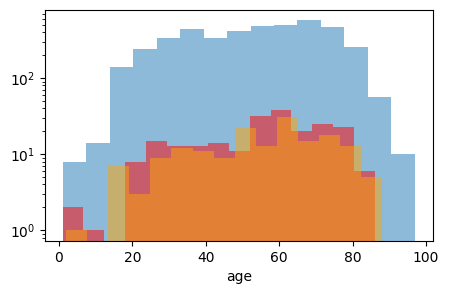

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "age"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "age"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "age"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("age")
plt.show()

## TSH

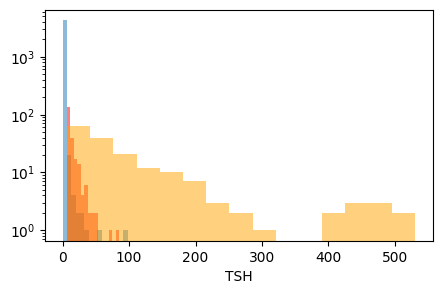

In [15]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "TSH"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "TSH"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "TSH"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("TSH")
plt.show()

## T3

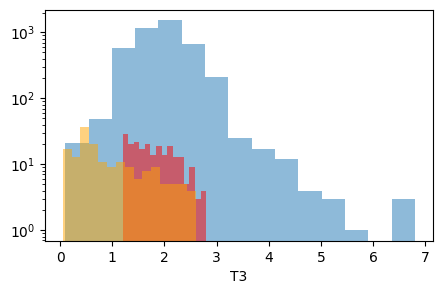

In [16]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "T3"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "T3"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "T3"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("T3")
plt.show()

## TT4

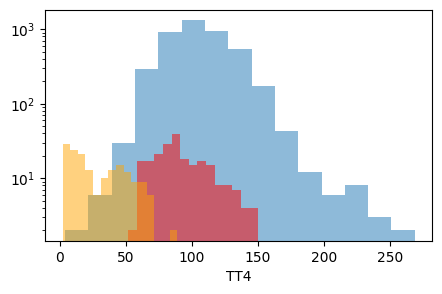

In [17]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "TT4"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "TT4"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "TT4"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("TT4")
plt.show()

## T4U

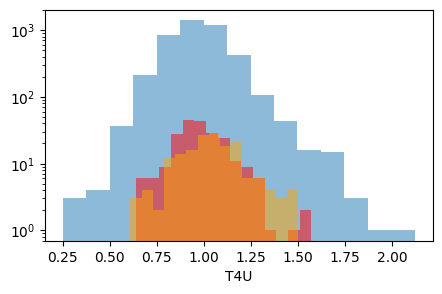

In [18]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "T4U"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "T4U"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "T4U"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("T4U")
plt.show()

## FTI

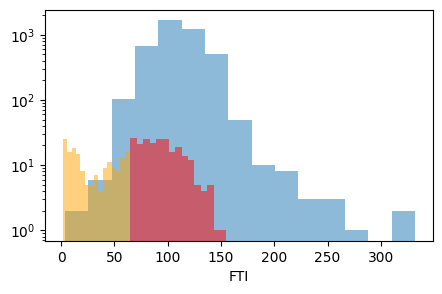

In [19]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "FTI"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "FTI"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "FTI"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("FTI")
plt.show()

\newpage

# Outliers detection

In [20]:
data_all = data[["age", "TSH", "T3", "TT4", "T4U", "FTI", "target"]].copy()
data_all.loc[data_all["target"]!=0, "target"] = 1

x_train = data_all[["age", "TSH", "T3", "TT4", "T4U", "FTI"]].to_numpy().copy()
labels_train = data_all["target"].to_numpy().copy()

In [21]:
bandwidth = direct_plugin(x_train)

## Siatka po mnożniku h (przy r=0.083)
[0.5, 1, 2, 5, 10, 20, 50]

In [22]:
h_mul_grid = np.array([0.5, 1, 2, 5, 10, 20, 50])
metrics = []

for h_mul in h_mul_grid:
    print(f"Mnożnik h: {h_mul}")
    outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul, r=0.083)
    labels_pred = outliers_detector.predict(x_train)
    
    metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth*h_mul)
    metrics.append(metric)
    print(f"Wskaznik jakosci: {metric}")

    res = confusion_matrix(labels_train, labels_pred)
    print(res)

    print(f"precision: {res[1, 1] / res[:, 1].sum()}")
    print(f"recall: {res[1, 1] / res[1, :].sum()}")
    print(f"accuracy: {np.diag(res).sum() / res.sum()}")

    print("-"*30)

Mnożnik h: 0.5
Wskaznik jakosci: 0.9999999999999999
[[3924  369]
 [  72  318]]
precision: 0.462882096069869
recall: 0.8153846153846154
accuracy: 0.905829596412556
------------------------------
Mnożnik h: 1.0
Wskaznik jakosci: 0.9999998151882795
[[4122  171]
 [ 172  218]]
precision: 0.5604113110539846
recall: 0.558974358974359
accuracy: 0.9267563527653214
------------------------------
Mnożnik h: 2.0
Wskaznik jakosci: 0.9858216427320965
[[4129  164]
 [ 165  225]]
precision: 0.5784061696658098
recall: 0.5769230769230769
accuracy: 0.929745889387145
------------------------------
Mnożnik h: 5.0
Wskaznik jakosci: 0.6780198419653942
[[4155  138]
 [ 139  251]]
precision: 0.6452442159383034
recall: 0.6435897435897436
accuracy: 0.9408498825539184
------------------------------
Mnożnik h: 10.0
Wskaznik jakosci: 0.7725574221943343
[[4144  149]
 [ 150  240]]
precision: 0.6169665809768637
recall: 0.6153846153846154
accuracy: 0.9361520392910527
------------------------------
Mnożnik h: 20.0
Wskazni

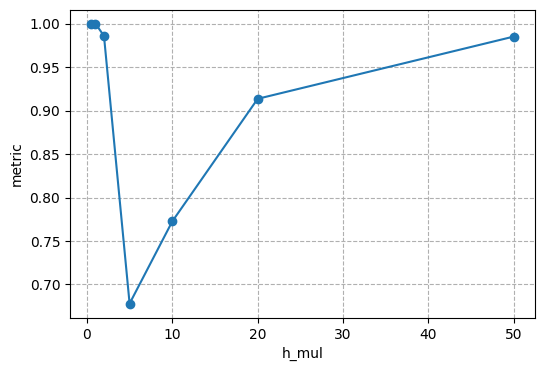

In [23]:
plt.figure(figsize=(6, 4))

plt.plot(h_mul_grid, metrics, "-o")

plt.xlabel("h_mul")
plt.ylabel("metric")
plt.grid(linestyle="--")
plt.show()

\newpage

## Siatka po r

[0.01, 0.02, 0.03, ..., 0.5]

In [24]:
r_grid = np.arange(0.01, 0.51, 0.01)
metrics = []

for r in r_grid:
    print(f"r: {r:.2f}")
    outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=r)
    labels_pred = outliers_detector.predict(x_train)
    
    metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth)
    metrics.append(metric)
    print(f"Wskaznik jakosci: {metric}")

    res = confusion_matrix(labels_train, labels_pred)
    print(res)

    print(f"precision: {res[1, 1] / res[:, 1].sum()}")
    print(f"recall: {res[1, 1] / res[1, :].sum()}")
    print(f"accuracy: {np.diag(res).sum() / res.sum()}")

    print("-"*30)

r: 0.01
Wskaznik jakosci: 0.9999999999999932
[[4232   61]
 [ 270  120]]
precision: 0.6629834254143646
recall: 0.3076923076923077
accuracy: 0.9293188127268844
------------------------------
r: 0.02
Wskaznik jakosci: 0.9999999999999932
[[4232   61]
 [ 270  120]]
precision: 0.6629834254143646
recall: 0.3076923076923077
accuracy: 0.9293188127268844
------------------------------
r: 0.03
Wskaznik jakosci: 0.9999999999999932
[[4232   61]
 [ 270  120]]
precision: 0.6629834254143646
recall: 0.3076923076923077
accuracy: 0.9293188127268844
------------------------------
r: 0.04
Wskaznik jakosci: 0.9999999999999671
[[4226   67]
 [ 265  125]]
precision: 0.6510416666666666
recall: 0.32051282051282054
accuracy: 0.9291052743967542
------------------------------
r: 0.05
Wskaznik jakosci: 0.9999999999938475
[[4210   83]
 [ 238  152]]
precision: 0.6468085106382979
recall: 0.38974358974358975
accuracy: 0.931454196028187
------------------------------
r: 0.06
Wskaznik jakosci: 0.9999999993919741
[[4190  1

Wskaznik jakosci: 0.994789440202859
[[2567 1726]
 [   9  381]]
precision: 0.18082581869957284
recall: 0.9769230769230769
accuracy: 0.6295109972240017
------------------------------
r: 0.46
Wskaznik jakosci: 0.9952921389604209
[[2522 1771]
 [   7  383]]
precision: 0.1778087279480037
recall: 0.982051282051282
accuracy: 0.6203288490284006
------------------------------
r: 0.47
Wskaznik jakosci: 0.9954718004798299
[[2475 1818]
 [   7  383]]
precision: 0.17401181281235803
recall: 0.982051282051282
accuracy: 0.6102925475122785
------------------------------
r: 0.48
Wskaznik jakosci: 0.9944126219054894
[[2428 1865]
 [   7  383]]
precision: 0.17037366548042704
recall: 0.982051282051282
accuracy: 0.6002562459961563
------------------------------
r: 0.49
Wskaznik jakosci: 0.9944869576157022
[[2381 1912]
 [   7  383]]
precision: 0.16688453159041394
recall: 0.982051282051282
accuracy: 0.5902199444800341
------------------------------
r: 0.50
Wskaznik jakosci: 0.9925146135933149
[[2335 1958]
 [   6

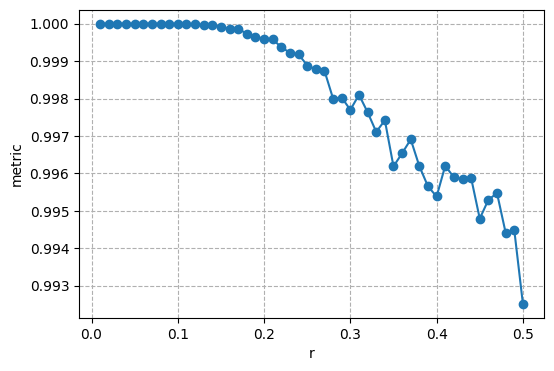

In [25]:
plt.figure(figsize=(6, 4))

plt.plot(r_grid, metrics, "-o")

plt.xlabel("r")
plt.ylabel("metric")
plt.grid(linestyle="--")
plt.show()

\newpage

## Siatka po mnożniku h oraz r

In [26]:
best_metric = np.inf
for h_mul in h_mul_grid:
    for r in r_grid:
        kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
        labels_pred = kde_outlier_detector.predict(x_train)
        metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
        if metric < best_metric:
            best_h_mul = h_mul
            best_r = r
            best_metric = metric

print(f"Najlepszy mnożnik h: {best_h_mul:.2f} oraz r {best_r:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h: 50.00 oraz r 0.01
Przy wskaźniku jakości: 0.047168


In [27]:
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*best_h_mul, r=best_r)
labels_pred = outliers_detector.predict(x_train)
res = confusion_matrix(labels_train, labels_pred)
print(res)

print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

[[4293    0]
 [ 343   47]]
precision: 1.0
recall: 0.12051282051282051
accuracy: 0.9267563527653214
